# <center>**Mini-projet n°5 : Le réchauffement climatique (Combes Robin)**</center>

___

## <ins>Objectif :</ins>

###### [Texte intégralement issu du sujet du Mini-projet n°5]

On va tenter de répondre dans ce projet à une question : des mesures de température mesurées localement au cours du dernier siècle mettent-elles en évidence un réchauffement significatif ? On va travailler pour répondre à cette question sur les relevés de température enregistrés quotidiennement depuis juin 1920 à [la station météorologique de Montélimar](https://donneespubliques.meteofrance.fr/metadonnees_publiques/fiches/fiche_26198001.pdf). Elles peuvent être téléchargées librement depuis le [site de l'ECAD](https://www.ecad.eu/) (European Climate Assessment & Dataset).

## I) <ins>Démarche :</ins>

Nous allons dans un premier temps chercher à dégager un comportement affine dans l'évolution des données de températures recueillies.
<br>On espère ainsi mettre en évidence un phénomène de réchauffement local (situation géographique de la commune de Montélimar) faible et lent, en déterminant la droite affine qui minimise la somme des carrés des écarts des données à celle-çi, sur toute la période de temps s'étalant de l'an 1920 environ à l'an 2019.
<br>On utilisera pour cela une implémentation en python de la méthode des moindres carrés via la fonction [*__curve_fit__*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) du module **scipy.optimize**, en considérant une incertitude type sur les mesures de températures de l'ordre de 5°C.

In [2]:
"""Import des modules nécessaires"""
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as tick
from scipy.optimize import curve_fit
from IPython.display import display,Latex

In [3]:
"""Récupération des données de températures relevées sous forme de dataframe"""
df=pd.DataFrame(np.loadtxt('montelimar_temperature.dat'))
#On convertit en années du calendrier Grégorien actuel les données de l'échelle temporelle initialement exprimées en Jour Julien modifié (MJD) 
df[0]=df[0].apply(lambda x : (x+2400000.5)/365.25-4713)

In [4]:
"""On définit la fonction avec laquelle on souhaite ajuster les données"""
def to_adjust_1(x,a,b):
    return a*x+b

In [5]:
"""On définit la fonction résultant de l'ajustement"""
params,cov=curve_fit(to_adjust_1,df[0],df[1],sigma=[5]*len(df[1]),absolute_sigma=True)
def adjusted_1(x):
    return params[0]*x+params[1]

In [6]:
"""On définit la fonction permettant d'afficher les courbes attendues"""
def plot_1(x,y,f):
    plt.figure(figsize=(20,7)) 
    plt.plot(x,y, label="Courbe issue des données brutes relevées")
    plt.plot(x,f(x), label="Courbe issue de l'ajustement affine")
    plt.suptitle("Évolution de la température en fonction du temps [~1920 à ~2019] sur la commune de Montélimar",fontsize=15, fontweight='light', horizontalalignment='center',y=0.94)
    plt.xlabel('Temps (année grégorienne)',fontsize=12,labelpad=9)
    plt.ylabel('Température (°C)',fontsize=12,labelpad=7)
    plt.grid()
    plt.legend()
    plt.show()

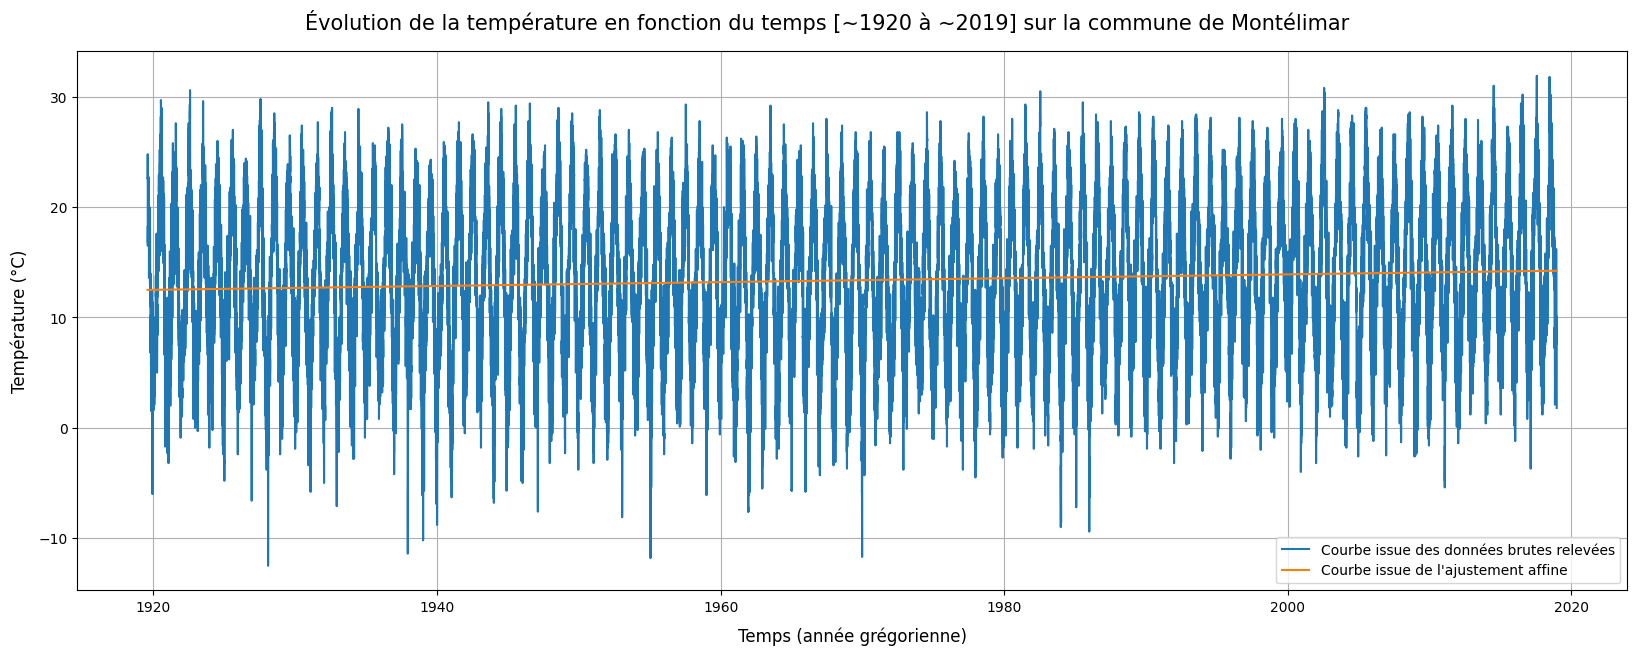

<IPython.core.display.Latex object>

In [7]:
"""On affiche finalement les courbes en appelant la fonction"""
plot_1(df[0],df[1],adjusted_1)
#On affiche le coefficient directeur de la droite affine issue de l'ajustement
display(Latex("La valeur de la pente de l'ajustement affine obtenue est de : {} $\pm$ {}".format(round(params[0],6),round(np.sqrt(cov[0,0]),6))))

###### [$\downarrow$(retour)](#id_2nd)

<a id="id_1st"></a>On constate ainsi bien un tendance globale à l'augmentation lente (comparée aux variations d'amplitudes journalinères ou saisonnières) et faible des températures sur la période s'étalant de l'an 1920 à l'an 2019, avec une hausse d'environ $1.7°\mathrm{C}$ suivant le modèle affine établi.
<br>Le résultat obtenu est par ailleurs significatif étant donné la valeur de l'incertitude relative obtenue pour le coefficient directeur de la droite affine : $\sim 5.2 \,\%$.

On va désormais chercher à modéliser les variation saisonnières de température par une fonction sinusoïdale de période une année oscillant autour d'une valeur moyenne de température via : $\,\,\,\,\mathrm{T\,:\,t\longmapsto A \sin{(\omega t + \phi)} + B}$
<br>On va alors réaliser l'ajustement via la fonction *_curve_fit_* pour chaque décennie considérée séparément de façon à mettre en évidence une augmentation éventuelle du paramètre $\mathrm{B}$ (i.e. de la température moyenne).

In [8]:
"""On définit la fonction avec laquelle on souhaite ajuster les données"""
def to_adjust_2(t,A,B,ф):
    return A*np.sin((2*np.pi)*t+ф)+B

In [9]:
"""On crée le vecteur qui va contenir les intervalles correspondants à une durée de 10 ans"""
#On itinialise les vecteurs destinés respectivement à contenir les indices des bornes des décénies et les intervalles des indices des bornes des décénies
df_dec_indexes=[]
df_dec_intervals=[]
#On initialise la borne sup (année grégorienne) de la 1ère décennie
cursor=1930
#On initialise nos compteurs
i=0
k=0
#On crée le vecteur destiné à contenir les indices des bornes des décénies
while i!=(len(df[0])-1) and cursor<2018:
    if df[0][i]>=cursor:
        df_dec_indexes+=[i]
        cursor+=10
    i+=1
df_dec_indexes=np.repeat(df_dec_indexes,2)
df_dec_indexes=np.insert(df_dec_indexes,0,0)
df_dec_indexes=np.append(df_dec_indexes,len(df[0])-1)
#On crée le vecteur destiné à contenir les intervalles des indices des bornes des décénies
while k <len(df_dec_indexes)-1:
    df_dec_intervals+=[[df_dec_indexes[k],df_dec_indexes[k+1]]]
    k+=2

In [10]:
"""On définit la fonction résultant de l'ajustement"""
def adjusted_2(x,intervalle):
    params,cov=curve_fit(to_adjust_2,df[0].iloc[intervalle[0]:intervalle[1]],df[1].iloc[intervalle[0]:intervalle[1]],sigma=[5]*(len(df[1].iloc[intervalle[0]:intervalle[1]])),absolute_sigma=True)
    return params[0]*np.sin((2*np.pi)*x+params[2])+params[1],params[1]

In [11]:
"""On définit la fonction permettant d'afficher les courbes attendues"""
def plot_2(x,y,intervals):
    #On définit une fenêtre multi-graphique
    g,ax=plt.subplots(5,2,figsize=(15,20))
    #On crée un vecteur contenant les coordonnées des 10 axes composant la figure
    w=[(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]
    #On initialise la variable qui permettra d'itérer sur w
    i=0
    #On boucle sur les intervalles correspondant à une durée d'une décennie
    for interval in intervals:
        B=round(adjusted_2(x.iloc[interval[0]:interval[1]],interval)[1],3)
        X=x.iloc[interval[0]:interval[1]]
        Y=y.iloc[interval[0]:interval[1]]
        ax[w[i][0],w[i][1]].set_title("Décennie n°{}".format(i+1),fontsize=15, fontweight='light', horizontalalignment='center', y=1.02)
        ax[w[i][0],w[i][1]].set_xlabel('Temps (année grégorienne)',fontsize=12,labelpad=9)
        ax[w[i][0],w[i][1]].set_ylabel('Température (°C)',fontsize=12,labelpad=7)
        ax[w[i][0],w[i][1]].plot(X,Y, label="Courbe issue des données brutes relevées")
        ax[w[i][0],w[i][1]].plot(X,adjusted_2(X,interval)[0], label="Courbe issue de l'ajustement avec B={}".format(B))
        ax[w[i][0],w[i][1]].grid()
        ax[w[i][0],w[i][1]].legend(loc='lower left')
        i+=1
    g.tight_layout(w_pad=3,h_pad=3)
    plt.show()

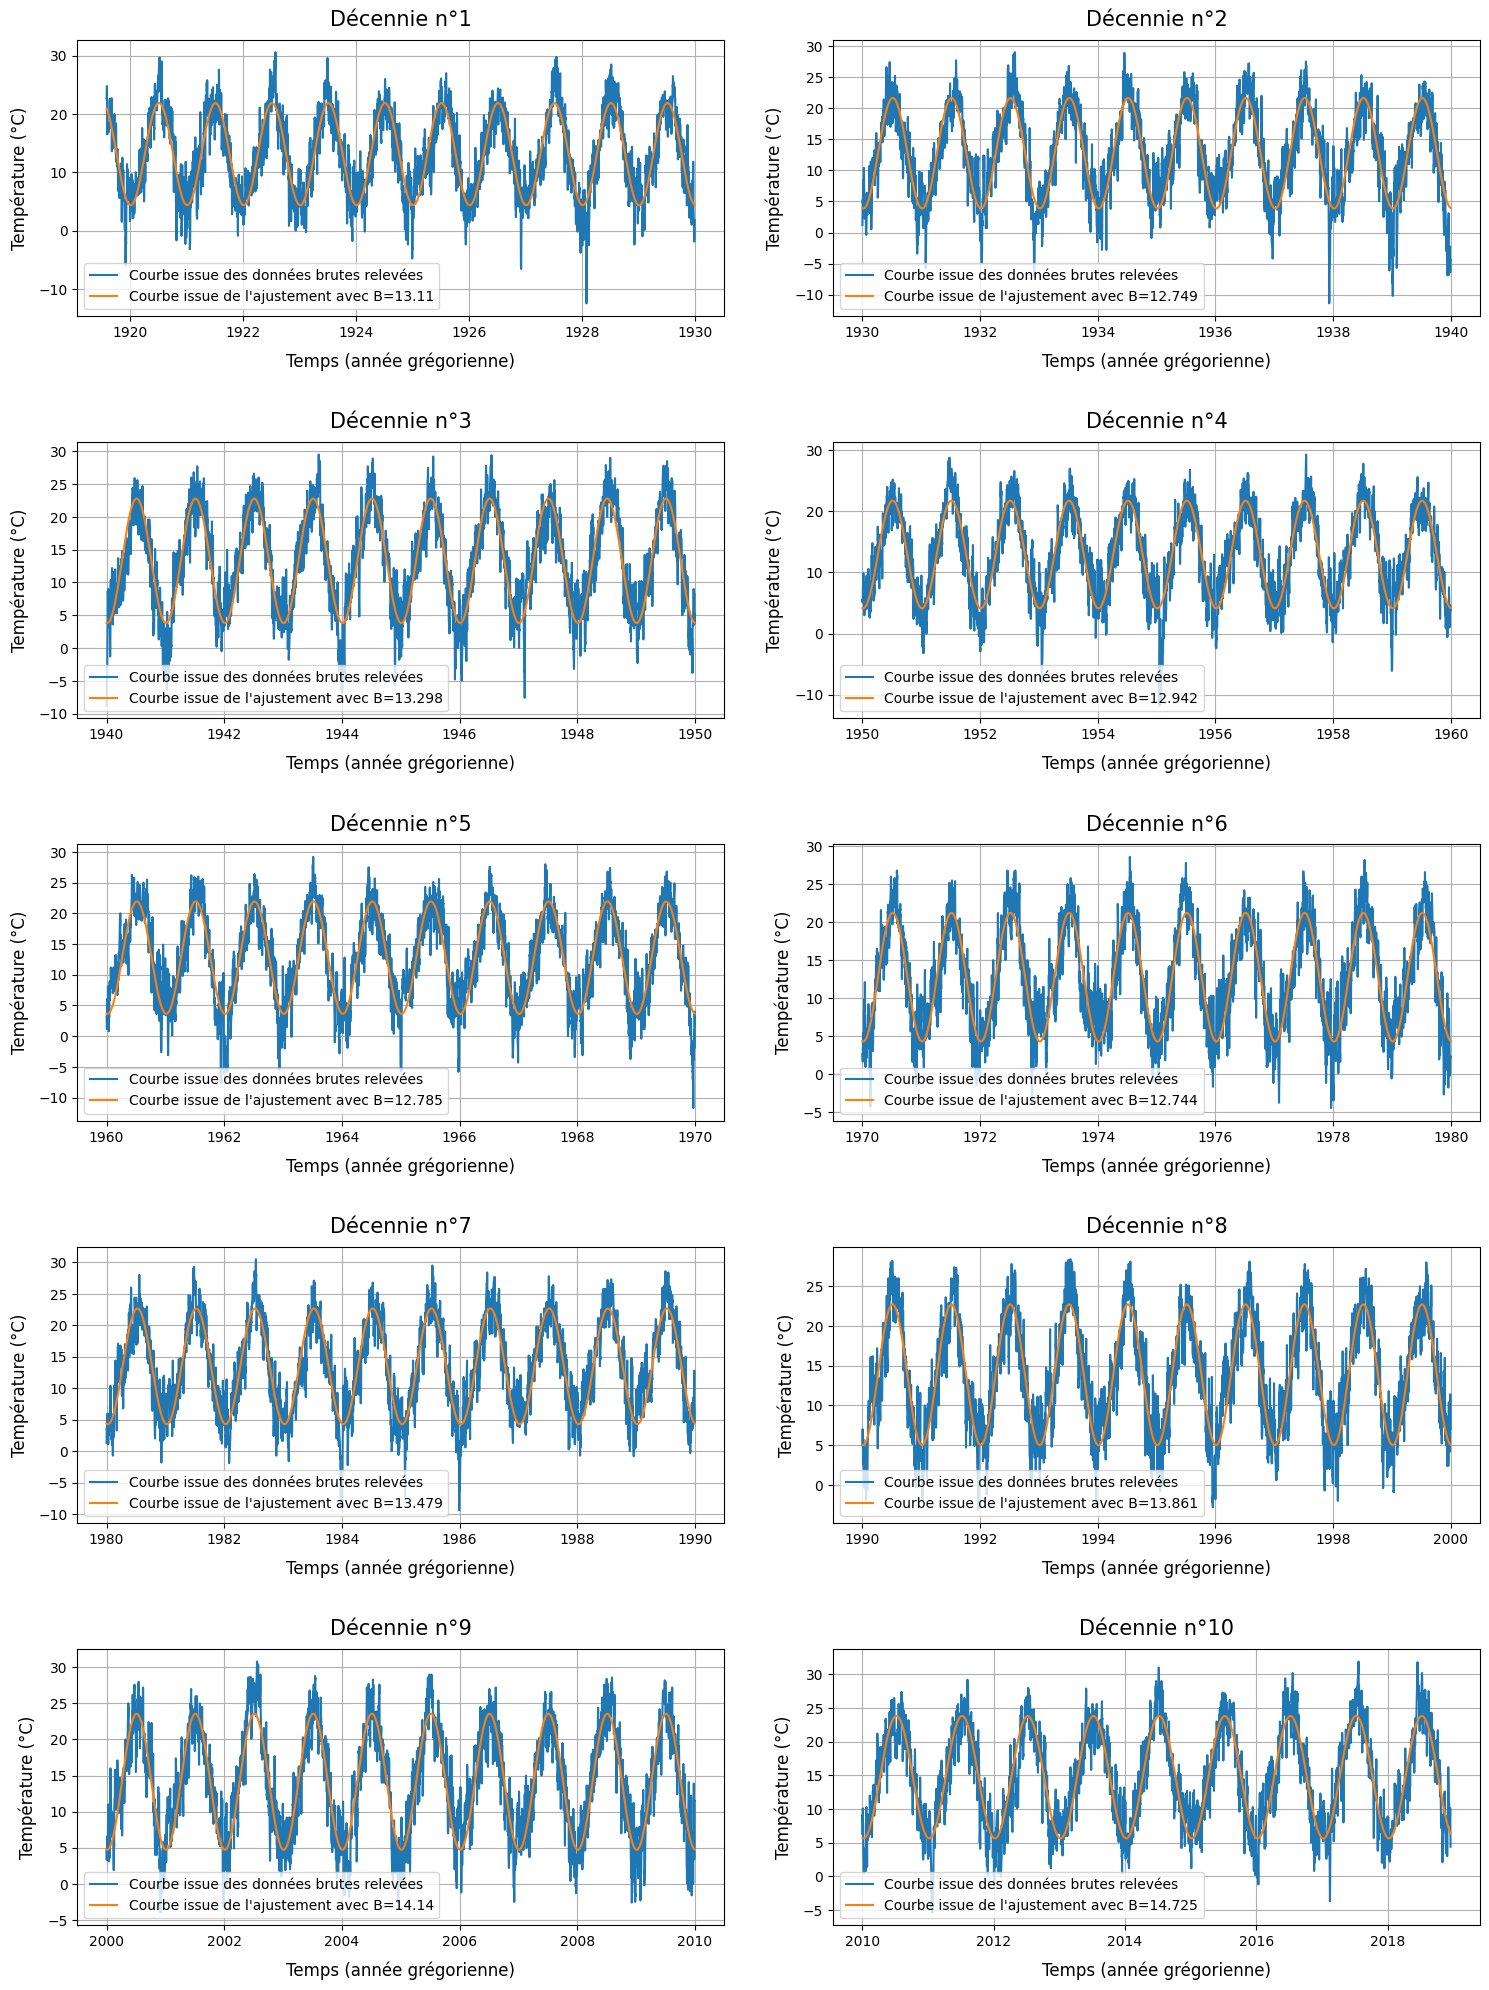

In [12]:
"""On affiche finalement les courbes en appelant la fonction"""
plot_2(df[0],df[1],df_dec_intervals)

On identifie ainsi bien une hausse permanente du paramètre jouant le rôle de la température moyenne dans notre modèle, au cours des décennies qui ont suivi l'an 1970, passant d'environ $12.744°\mathrm{C}$ à environ $14.725°\mathrm{C}$.

Au vu de la constatation précédente, on se propose finalement de préciser le modèle précédent en considérant une évolution affine de la tempéraure moyenne, de sorte que l'évolution saisonnière de température puisse être modélisée par : $\,\,\,\,\mathrm{T\,:\,t\longmapsto A \sin{(\omega t + \phi)} + B + C.t}$
<br>On réalise une fois de plus un ajustement en utilisant la fonciton *_curve_fit_* via le programme çi-dessous.

In [13]:
"""On définit la fonction avec laquelle on souhaite ajuster les données"""
def to_adjust_3(t,A,B,C,ф):
    return A*np.sin((2*np.pi)*t+ф)+B+C*t

In [14]:
"""On définit la fonction résultant de l'ajustement"""
params,cov=curve_fit(to_adjust_3,df[0],df[1],sigma=[5]*len(df[1]),absolute_sigma=True)
def adjusted_3(x):
    return params[0]*np.sin((2*np.pi)*x+params[3])+params[1]+params[2]*x

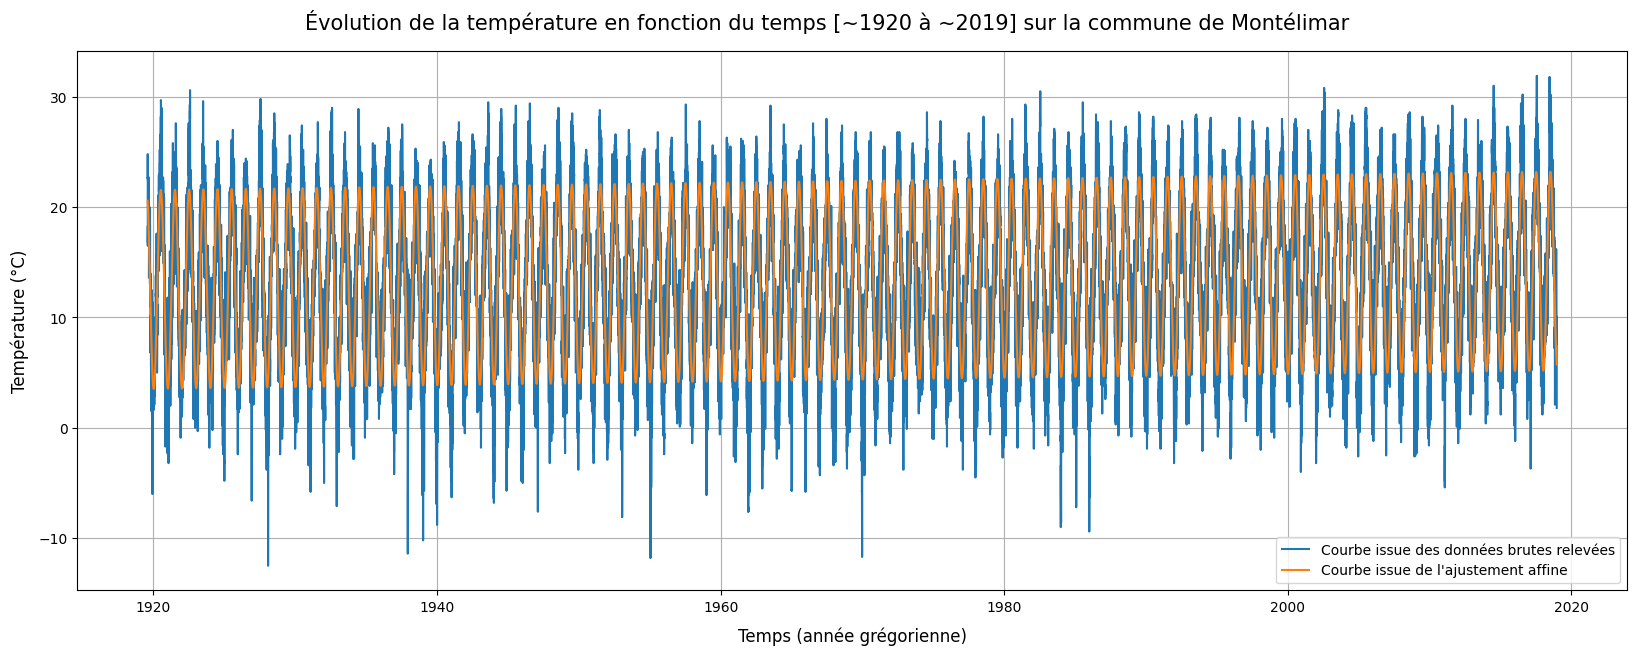

<IPython.core.display.Latex object>

Il en résulte une hausse de température d'environ 1.7°C sur la période s'étalant d'environ 1920 à 2019


In [16]:
"""On affiche finalement les courbes en appelant la fonction"""
plot_1(df[0],df[1],adjusted_3)
#On affiche le coefficient directeur de la droite affine issue de l'ajustement
display(Latex("La valeur de la pente de la composante affine de l'ajustement obtenue est de : {} $\pm$ {}".format(round(params[2],6),round(np.sqrt(cov[2,2]),6))))
print("Il en résulte une hausse de température d'environ {}°C sur la période s'étalant d'environ 1920 à 2019".format(round((lambda t : params[1]+params[2]*t)(df.iloc[-1,0])-(lambda t : params[1]+params[2]*t)(df.iloc[0,0]),1)))

On retrouve ainsi l'ordre de grandeur de la pente déterminée en premier lieu ([ici](#id_1st)). <a id='id_2nd'></a>
<br>Le résultat obtenu est là aussi significatif au vu de la valeur de l'incertitude relative obtenue pour le coefficient directeur de la droite affine : $\sim 5.4 \,\%$.